In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM

In [2]:
df = pd.read_csv("/content/drive/MyDrive/DEEP LEARNING/Gold Dataset.csv")

In [3]:
df

,Date,Open,High,Low,Price
0,"Mar 08, 2024","2,167.30","2,194.90","2,166.30","2,178.60"
1,"Mar 07, 2024","2,147.00","2,163.00","2,147.00","2,158.00"
2,"Mar 06, 2024","2,125.50","2,150.30","2,125.50","2,150.30"
3,"Mar 05, 2024","2,114.90","2,133.50","2,111.40","2,133.50"
4,"Mar 04, 2024","2,083.60","2,119.80","2,080.70","2,117.70"
...,...,...,...,...,...
3577,NaN,NaN,NaN,NaN,NaN
3578,NaN,NaN,NaN,NaN,NaN
3579,NaN,NaN,NaN,NaN,NaN
3580,NaN,NaN,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3582 entries, 0 to 3581
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    3571 non-null   object
 1   Open    3571 non-null   object
 2   High    3571 non-null   object
 3   Low     3571 non-null   object
 4   Price   3571 non-null   object
dtypes: object(5)
memory usage: 140.0+ KB


In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [6]:
df.isnull().sum().sum()

55

In [7]:
df.duplicated().sum()

10

In [8]:
df = df.dropna()

In [9]:
df.duplicated().sum()

0

In [10]:
# List of numeric columns excluding 'Date'
NumCols = df.columns.drop(['Date'])

# Remove commas from numeric columns and convert them to float
for col in NumCols:
    df[col] = df[col].replace({',': ''}, regex=True)  # Remove commas
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric, coerce errors to NaN

# Drop rows with NaN values (assuming you want to remove rows with non-numeric values)
df = df.dropna()

# Display the resulting DataFrame
print(df)

           Date    Open    High     Low   Price
0    2010-01-05  1118.1  1126.5  1115.0  1118.1
1    2010-01-06  1135.9  1139.2  1120.7  1135.9
2    2010-01-07  1133.1  1133.1  1129.2  1133.1
3    2010-01-08  1138.2  1138.2  1122.7  1138.2
4    2010-01-11  1150.7  1161.2  1143.0  1150.7
...         ...     ...     ...     ...     ...
3566 2024-03-04  2083.6  2119.8  2080.7  2117.7
3567 2024-03-05  2114.9  2133.5  2111.4  2133.5
3568 2024-03-06  2125.5  2150.3  2125.5  2150.3
3569 2024-03-07  2147.0  2163.0  2147.0  2158.0
3570 2024-03-08  2167.3  2194.9  2166.3  2178.6

[3567 rows x 5 columns]


<ipython-input-10-4fb95145191e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].replace({',': ''}, regex=True)  # Remove commas
<ipython-input-10-4fb95145191e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric, coerce errors to NaN


In [11]:
df.head()

,Date,Open,High,Low,Price
0,2010-01-05,1118.1,1126.5,1115.0,1118.1
1,2010-01-06,1135.9,1139.2,1120.7,1135.9
2,2010-01-07,1133.1,1133.1,1129.2,1133.1
3,2010-01-08,1138.2,1138.2,1122.7,1138.2
4,2010-01-11,1150.7,1161.2,1143.0,1150.7


In [12]:
fig = px.line(y=df.Price, x=df.Date)
fig.update_traces(line_color='black')
fig.update_layout(xaxis_title="Date",
                  yaxis_title="Scaled Price",
                  title={'text': "Gold Price History Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(255, 255, 255, 1)')

In [13]:
test_size = df[df.Date.dt.year>=2023].shape[0]
test_size

299

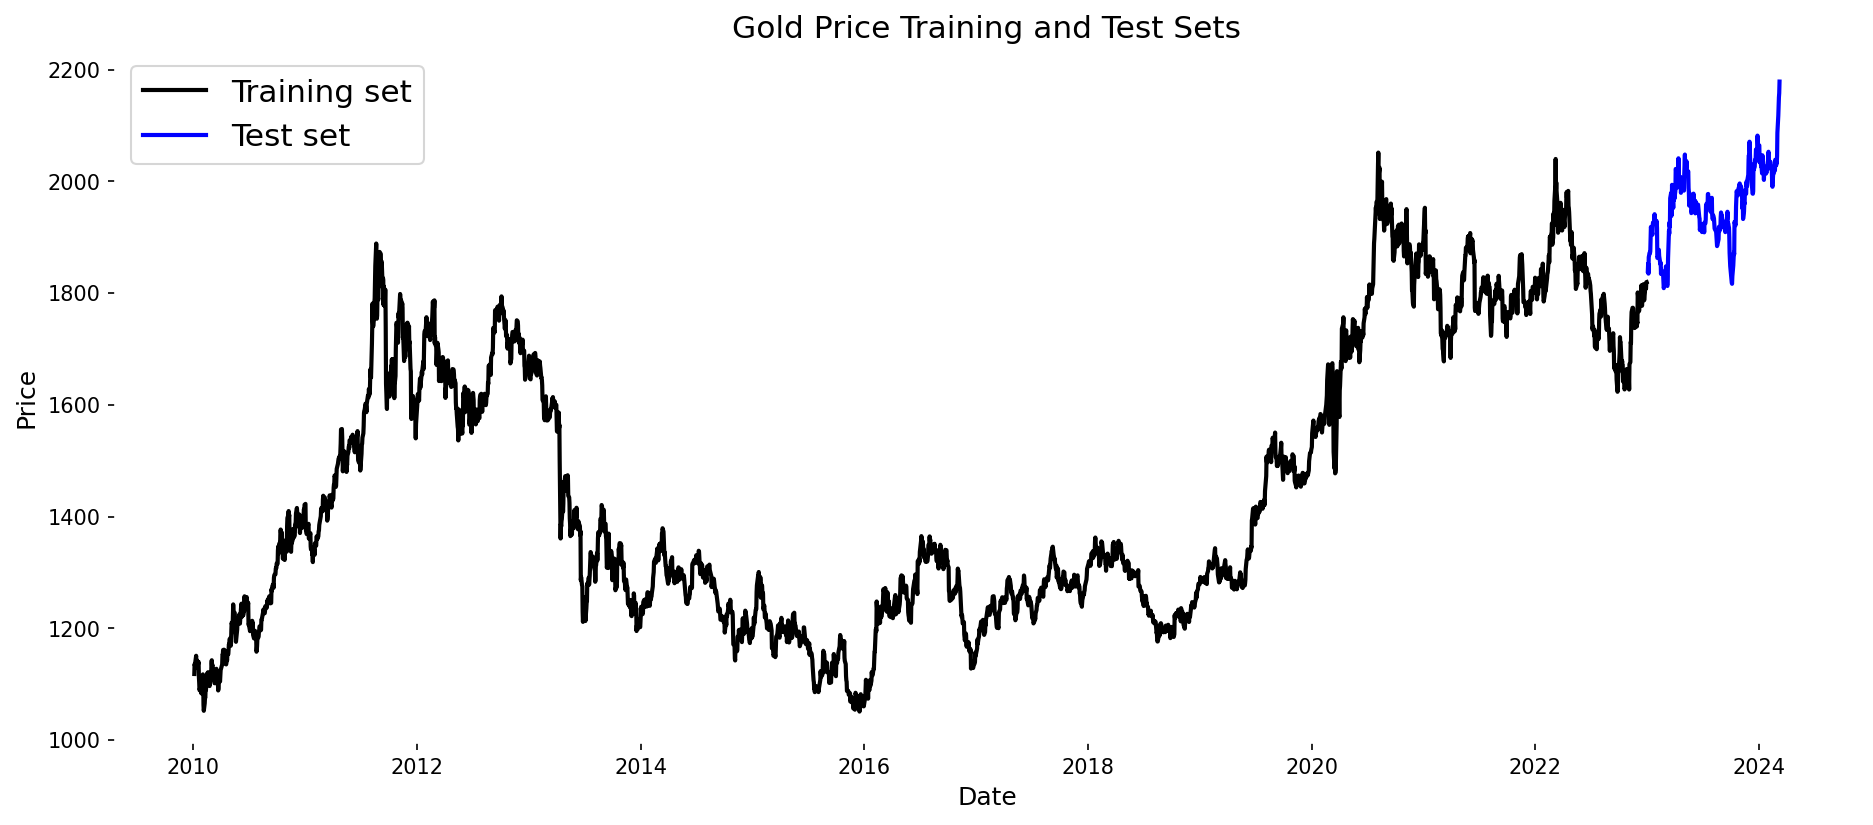

In [14]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='white')
plt.plot(df.Date[:-test_size], df.Price[:-test_size], color='black', lw=2)
plt.plot(df.Date[-test_size:], df.Price[-test_size:], color='blue', lw=2)
plt.title('Gold Price Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [15]:
scaler = MinMaxScaler()
scaler.fit(df.Price.values.reshape(-1,1))

MinMaxScaler()

In [16]:
window_size = 60

In [17]:
train_data = df.Price[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

In [18]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [19]:
test_data = df.Price[-test_size-60:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [20]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

In [21]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [22]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [23]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (3208, 60, 1)
y_train Shape:  (3208, 1)
X_test Shape:   (299, 60, 1)
y_test Shape:   (299, 1)


In [24]:
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 64, return_sequences=True)(input1)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()

    return model

In [26]:
model = define_model()
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 lstm_3 (LSTM)               (None, 60, 64)            16896     
                                                                 
 dropout_3 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_4 (LSTM)               (None, 60, 64)            33024     
                                                                 
 dropout_4 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0   

In [27]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

10/10 [==============================] - 1s 16ms/step


In [28]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE

In [29]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: 0.0017137759132310748
Test MAPE: 0.036341763513716506
Test Accuracy: 0.9636582364862835


In [30]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)